In [23]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import csv

import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
STOPWORDS = set(stopwords.words('english'))

#### Hyperparameter

In [9]:
vocab_size = 5000
embedding_dim = 64
max_length = 200
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
training_portion = 0.8

In [11]:
articles = []
labels = []

with open('./bbc-text.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    
    for row in reader:
        labels.append(row[0])
        
        article = row[1]
        
        for word in STOPWORDS:
            token = ' ' + word + ' '
            article = article.replace(token, ' ')
            article = article.replace(' ', ' ')
        
        articles.append(article)

len(articles), len(labels)

(2225, 2225)

#### split dataset

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(articles, labels, train_size=training_portion)

len(X_train), len(y_train), len(X_val), len(y_val)

(1780, 1780, 445, 445)

#### tokenizer

In [15]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index
dict(list(word_index.items())[:10])

{'<OOV>': 1,
 'said': 2,
 'mr': 3,
 'would': 4,
 'year': 5,
 'also': 6,
 'people': 7,
 'new': 8,
 'us': 9,
 'one': 10}

In [17]:
train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_sequences, maxlen=max_length)

In [18]:
print(train_padded[10])

[ 482 3943  228 4496 4115  180 2673 1056    1    5  294 1616  141   65
  391 1097 3509  506  950 2296 1618 1616  141 3943   43  432  523 4746
 2750  530  518 2059   13   46    2    4 1225 3112 2601 2601 2016  215
 2146 1098 3509   60  161 2536 1164 1532  206 4747 4748 2147 3943  190
    1 3944 4497    1   24  190   87  650    1    1  482 4498    1    8
 1676  650  432 1274  523 3030  951  914  523   46   49   87  432    1
 2750 2601  307   64 1941   87  650 3245 2601  229  180  536  927  582
 3031 2102 2601  213 1451  617 1645  650  432  523 2297  180  507 1555
 3656    1    1  434   15  452  336  482 3510  650 3511    4    1 1646
    2  650    4 3388  432  530 1451   74  160    1  694  181    1    9
 4499  206  845  223  139 4500    1  418    9  126 3799 1977 2404 2146
   10 3512 3032  103  900  890  846 2601   11  341  587 1388 3113  140
  950   11 2296  477  161 1703  281  318  365 1978  125  769 2146  281
  210  189 1125   65  289  806    1    4 1165   95  284 1019  193 1478
  213 

In [19]:
val_sequences = tokenizer.texts_to_sequences(X_val)
val_padded = pad_sequences(val_sequences, maxlen=max_length)

In [26]:
train_padded.shape, val_padded.shape

((1780, 200), (445, 200))

In [33]:
print(set(labels))
num_classes = len(set(labels))

{'politics', 'business', 'sport', 'entertainment', 'tech'}


In [24]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)

train_label_seq = label_tokenizer.texts_to_sequences(y_train)
val_label_seq = label_tokenizer.texts_to_sequences(y_val)

train_label_seq = np.array(train_label_seq)
val_label_seq = np.array(val_label_seq)

In [25]:
train_label_seq.shape, val_label_seq.shape

((1780, 1), (445, 1))

In [27]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_article(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_article(train_padded[10]))
print('----------')
print(X_train[10])

commission ec despite requests meps law proving controversial <OOV> year major tech firms say needed protect inventions others fear hurt smaller tech firms ec says council ministers adopt draft version agreed upon last may said would review aspects directive directive intended offer patent protection inventions use software achieve effect words computer implemented invention letter ec president <OOV> 233 manuel <OOV> told president european parliament <OOV> <OOV> commission intend <OOV> new proposal parliament council of ministers supported agreement reached ministers may 2004 european council <OOV> draft directive return second reading european parliament guarantee directive become law instead probably mean delays controversy directive eu legislation needs approval parliament council ministers becomes law french green mep <OOV> <OOV> warned two weeks ago commission ignored parliament request would <OOV> assembly said parliament would reject council version legislation part final <OOV>

#### Model

In [29]:
from keras.layers import Embedding, Bidirectional, Dense, LSTM
from keras.models import Sequential

In [38]:
model = Sequential([
    Embedding(vocab_size, embedding_dim),
    Bidirectional(LSTM(embedding_dim)),
    Dense(embedding_dim, activation='relu'),
    Dense(6, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 64)          320000    
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              66048     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 6)                 390       
                                                                 
Total params: 394,694
Trainable params: 394,694
Non-trainable params: 0
_________________________________________________________________


In [39]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(train_padded, train_label_seq, epochs=10, validation_data=(val_padded, val_label_seq))

Epoch 1/10
56/56 [==============================] - 15s 230ms/step - loss: 1.6327 - accuracy: 0.2624 - val_loss: 1.3835 - val_accuracy: 0.3483
Epoch 2/10
56/56 [==============================] - 13s 228ms/step - loss: 1.4049 - accuracy: 0.3837 - val_loss: 1.3854 - val_accuracy: 0.3348
Epoch 3/10
56/56 [==============================] - 13s 224ms/step - loss: 0.9553 - accuracy: 0.6298 - val_loss: 0.7714 - val_accuracy: 0.6944
Epoch 4/10
56/56 [==============================] - 13s 227ms/step - loss: 0.7528 - accuracy: 0.7185 - val_loss: 0.7457 - val_accuracy: 0.6854
Epoch 5/10
56/56 [==============================] - 13s 231ms/step - loss: 0.4734 - accuracy: 0.8281 - val_loss: 0.6543 - val_accuracy: 0.7551
Epoch 6/10
56/56 [==============================] - 13s 234ms/step - loss: 0.4705 - accuracy: 0.8472 - val_loss: 0.4820 - val_accuracy: 0.7596
Epoch 7/10
56/56 [==============================] - 13s 227ms/step - loss: 0.3678 - accuracy: 0.9107 - val_loss: 0.4019 - val_accuracy: 0.8742

In [36]:
import matplotlib.pyplot as plt

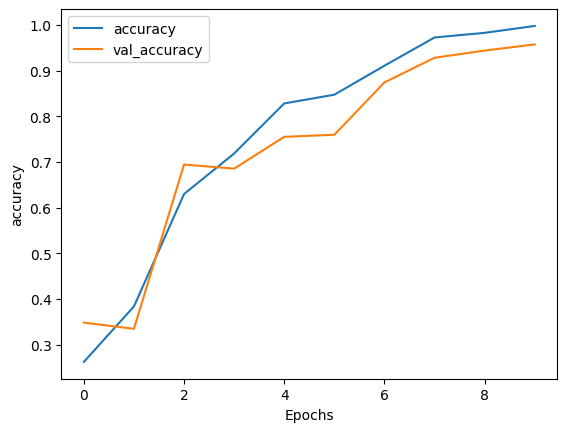

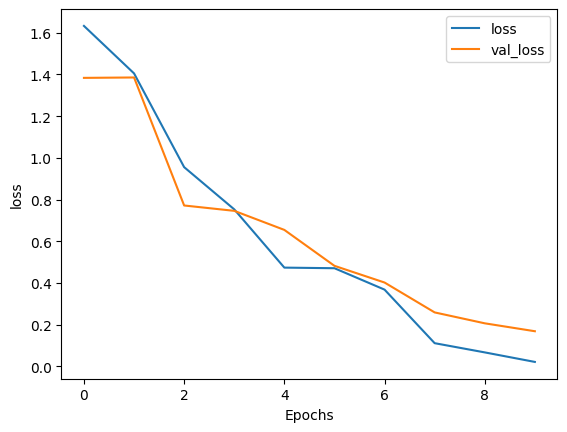

In [40]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

#### Predict

In [43]:
txt = ["A WeWork shareholder has taken the company to court over the near-$1.7bn (£1.3bn) leaving package approved for ousted co-founder Adam Neumann."]
seq = tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_length)

pred = model.predict(padded)
idx = np.argmax(pred)

label = label_tokenizer.word_index
true_label = list(label.keys())

print(f'category: {true_label[idx-1]}')

1/1 [==============================] - 0s 23ms/step


category: business
